In [168]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.preprocessing
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [169]:
numeros = sklearn.datasets.load_digits()
imagenes = numeros['images']  # Hay 1797 digitos representados en imagenes 8x8
n_imagenes = len(imagenes)
X = imagenes.copy()
Y = numeros['target']
print(np.shape(X))

(1797, 8, 8)


In [170]:
inputs = torch.autograd.Variable(torch.Tensor(X).float()).unsqueeze(1)
print(inputs.size())

torch.Size([1797, 1, 8, 8])


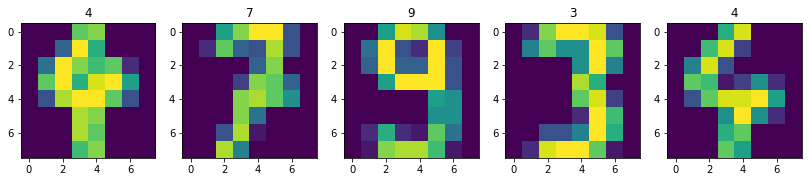

In [171]:
# muestra algunos ejemplos

n_items = inputs.data.size()[0]
random_items = np.random.choice(np.arange(n_items), 5)

plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    item  = random_items[i]
    plt.imshow(inputs[item][0].detach().numpy())
    plt.title(Y[item])

In [172]:
# normaliza
mean = inputs.mean(dim=0)
std = inputs.std(dim=0)
std[std==0]=1.0

for i in range(len(inputs)):
    inputs[i] = (inputs[i])/std
np.shape(inputs)



torch.Size([1797, 1, 8, 8])

# Los que se van a graficar

In [173]:
#Número total de parámetros de la red convolucional
N_Cs=[]
#Dimensionalidad del espacio latente
N_Ls=[]
#losses
losses=[]

# Primera corrida aumentando la dimensionalidad de los canales al final de ENCODER

In [174]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3),
            torch.nn.Conv2d(32,16,kernel_size=3),
            torch.nn.Conv2d(16,10,kernel_size= 3))
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=3),
            torch.nn.ConvTranspose2d(8,16,kernel_size=3),
            torch.nn.ConvTranspose2d(16,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [175]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [176]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.4961
epoch [26/100], loss:0.6808
epoch [51/100], loss:0.5147
epoch [76/100], loss:0.4322
epoch [100/100], loss:0.3808


In [177]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())

torch.Size([1797, 10, 2, 2])


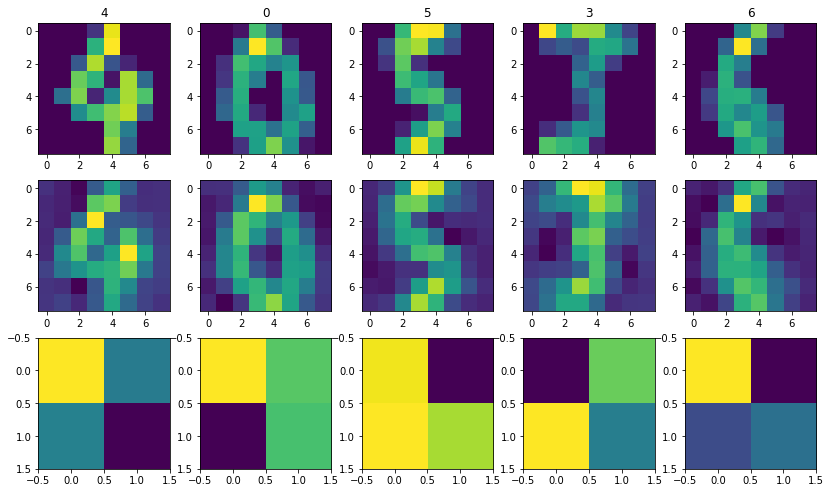

In [178]:
# muestra los resultados de las cuatro capas de convolucion
plt.figure(figsize=(14,14))
offset = 100
for i in range(5):
    plt.subplot(5,5,i+1) #imagenes originales
    plt.imshow((inputs[i+offset][0].detach().numpy()))
    plt.title(Y[i+offset])
    
    j=0 # las imagenes reconstruidas por el autoencoder
    plt.subplot(5,5,(i+1)+5*(j+1))
    plt.imshow(x_transform[i+offset][0].detach().numpy())
    
    j=1 # una de las capas de la representacion latente
    plt.subplot(5,5,(i+1)+5*(j+1))
    plt.imshow(latent_space[i+offset][0].detach().numpy())


In [180]:
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])
print(latent_space.size())
print(loss.item())


8435
torch.Size([1797, 10, 2, 2])
0.3807767629623413


# Segunda corrida introduciendo un stride al inicio de ENCODER

In [181]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3,stride=1),
            torch.nn.Conv2d(32,16,kernel_size=3),
            torch.nn.Conv2d(16,10,kernel_size= 3))
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=3),
            torch.nn.ConvTranspose2d(8,16,kernel_size=3),
            torch.nn.ConvTranspose2d(16,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [182]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [183]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.1578
epoch [26/100], loss:0.7530
epoch [51/100], loss:0.5113
epoch [76/100], loss:0.4167
epoch [100/100], loss:0.3686


In [184]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 2, 2])
8435


# Tercera: Aumentando la profundidad de la red ENCODER en una capa más

In [185]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 50, kernel_size=2),
            torch.nn.Conv2d(50,32,kernel_size=2),
            torch.nn.Conv2d(32,16,kernel_size= 3),
            torch.nn.Conv2d(16,10,kernel_size= 3))
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=3),
            torch.nn.ConvTranspose2d(8,16,kernel_size=3),
            torch.nn.ConvTranspose2d(16,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [186]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [187]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.3095
epoch [26/100], loss:0.7862
epoch [51/100], loss:0.5382
epoch [76/100], loss:0.4384
epoch [100/100], loss:0.3798


In [188]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 2, 2])
14797


# Cuarta: Aumentar el Kernel modificando lo que sea necesario

In [189]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=5),
            torch.nn.Conv2d(8,10,kernel_size=3))
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=3),
            torch.nn.ConvTranspose2d(8,16,kernel_size=3),
            torch.nn.ConvTranspose2d(16,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [190]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [191]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.5551
epoch [26/100], loss:0.8070
epoch [51/100], loss:0.5721
epoch [76/100], loss:0.4909
epoch [100/100], loss:0.4266


In [192]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 2, 2])
2979


# Quinta: 

In [193]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3),
            torch.nn.Conv2d(32,16,kernel_size=3),
            torch.nn.Conv2d(16,10,kernel_size= 3))
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=5),
            torch.nn.ConvTranspose2d(8,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [194]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [195]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:1.9018
epoch [26/100], loss:0.6307
epoch [51/100], loss:0.4716
epoch [76/100], loss:0.3808
epoch [100/100], loss:0.3138


In [196]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 2, 2])
8475


# Sexta:

In [197]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=1),
            torch.nn.Conv2d(32,16,kernel_size=1),
            torch.nn.Conv2d(16,10,kernel_size= 1))
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=1),
            torch.nn.ConvTranspose2d(8,1,kernel_size=1))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [198]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [199]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:4.0377
epoch [26/100], loss:0.1005
epoch [51/100], loss:0.0064
epoch [76/100], loss:0.0006
epoch [100/100], loss:0.0000


In [200]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 8, 8])
859


# Séptima:

In [201]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=2),
            torch.nn.Conv2d(32,16,kernel_size=2),
            torch.nn.Conv2d(16,10,kernel_size= 2))
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=3),
            torch.nn.ConvTranspose2d(8,1,kernel_size=2))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [202]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [203]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.0173
epoch [26/100], loss:0.4316
epoch [51/100], loss:0.3031
epoch [76/100], loss:0.2626
epoch [100/100], loss:0.2431


In [204]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 5, 5])
3635


# Octava:

In [208]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3),
            torch.nn.Conv2d(32,10,kernel_size=2))
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=3),
            torch.nn.ConvTranspose2d(8,1,kernel_size=2))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [209]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [210]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.0729
epoch [26/100], loss:0.4994
epoch [51/100], loss:0.3645
epoch [76/100], loss:0.2937
epoch [100/100], loss:0.2553


In [211]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 5, 5])
2371


# Novena

In [212]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=2),
            torch.nn.Conv2d(32,16,kernel_size=2),
            torch.nn.Conv2d(16,10,kernel_size= 4))
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=4),
            torch.nn.ConvTranspose2d(8,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [213]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [214]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:3.1665
epoch [26/100], loss:0.7197
epoch [51/100], loss:0.4703
epoch [76/100], loss:0.3773
epoch [100/100], loss:0.3251


In [215]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 3, 3])
6155


# Décima

In [216]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=4),
            torch.nn.Conv2d(16,10,kernel_size=3))
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(10,8,kernel_size=4),
            torch.nn.ConvTranspose2d(8,1,kernel_size=3))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [217]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)

In [218]:
# entrenamiento
loss_list = [] 
for epoch in range(num_epochs):
    output = model(inputs)
    loss = distance(output, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch==0 or epoch==25 or epoch==50 or epoch==75 or epoch==99:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/100], loss:2.1130
epoch [26/100], loss:0.4928
epoch [51/100], loss:0.3488
epoch [76/100], loss:0.2765
epoch [100/100], loss:0.2257


In [219]:
x_transform = model(inputs)
latent_space = model.encoder(inputs)
print(latent_space.size())
n_p=0
for m in model.parameters():
    n_p+=m.flatten().size()[0]
print(n_p)
N_Cs.append(n_p)
losses.append(loss.item())
N_Ls.append(latent_space.size()[2])

torch.Size([1797, 10, 3, 3])
3083


# Las gráficas

In [220]:
losses

[0.3807767629623413,
 0.3807767629623413,
 0.36859413981437683,
 0.3798326253890991,
 0.42660781741142273,
 0.3137870728969574,
 2.9978837119415402e-05,
 0.24308182299137115,
 0.2553066313266754,
 0.325053334236145,
 0.22566747665405273]

Text(0.5, 1.0, 'N_Cs vs N_Ls')

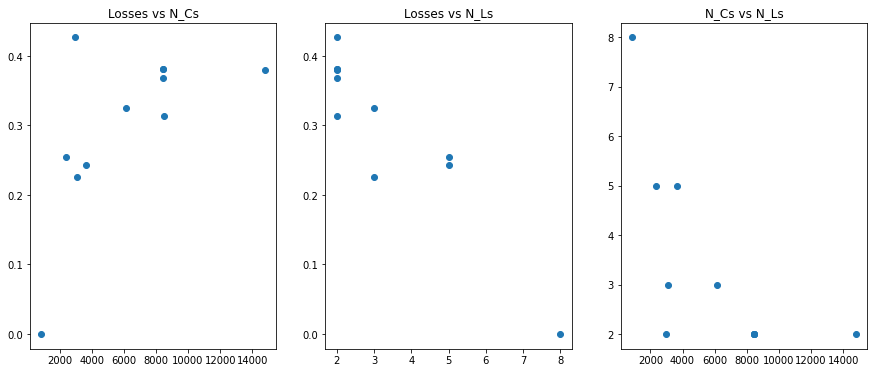

In [223]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(N_Cs,losses)
plt.title("Losses vs N_Cs")
plt.subplot(1,3,2)
plt.scatter(N_Ls,losses)
plt.title("Losses vs N_Ls")
plt.subplot(1,3,3)
plt.scatter(N_Cs,N_Ls)
plt.title("N_Cs vs N_Ls")